# 基于CNN的文本情感分类



## 1. 导入数据


In [ ]:
import pandas as pd
import numpy as np

# 文本处理相关
from nltk.tokenize import word_tokenize  # 文本分解为单词
import re  # 正则文本处理

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer  # 文本转换为整数索引表示
from tensorflow.keras.preprocessing.sequence import pad_sequences  # 不同长度的文本填充为相同的长度
from tensorflow.keras.utils import to_categorical  # 标签转换为分类编码

from tensorflow.keras.models import Sequential  # 创建顺序模型
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense  # 定义各层


import nltk
nltk.download('punkt')  # 下载分词所需的资源

from IPython import get_ipython
from IPython.display import display

import urllib.request
import zipfile
import os


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### *定义向量空间维度和固定的输入大小：*



In [ ]:
num_classes = 5

embed_num_dims = 300

max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']


*导入训练和测试数据集*

In [ ]:
#UTF-8 编码
data_train = pd.read_csv('data_train.csv', encoding='utf-8')
data_test = pd.read_csv('data_test.csv', encoding='utf-8')

# 提取特征
X_train = data_train.Text
X_test = data_test.Text

# 提取目标
y_train = data_train.Emotion
y_test = data_test.Emotion

data = pd.concat([data_train, data_test], ignore_index=True)


In [ ]:
# 每个情感类别的样本数量
print(data.Emotion.value_counts())

data.head(6)

Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


## 2. 数据预处理

In [ ]:
def clean_text(data):
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)

    # 使用 NLTK 进行分词，将文本拆分为单词
    data = word_tokenize(data)

    # 返回处理后的分词结果
    return data

In [ ]:
nltk.download('punkt_tab')

# 将分词结果重新拼接为一个字符串
texts = [' '.join(clean_text(text)) for text in data.Text]
texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
print(texts_train[92])

a bit ? I 'm extremely annoyed that he did n't phone me when he promised me that he would ! He 's such a liar .


### 分词

In [ ]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# 唯一单词的数量
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))


Number of unique words: 12087


### 填充


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen=max_seq_len)
X_test_pad = pad_sequences(sequence_test, maxlen=max_seq_len)

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10258,   173,    13]], dtype=int32)

In [ ]:
# 将情感标签映射为整数标签
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

###  导入预训练的词向量

从文件导入预训练的 word2vec 并创建嵌入矩阵
后续我们将把语料库中的每个单词映射到现有的词向量


In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    # 预训练的 word2vec 文件
    with open(filepath) as f:
        for line in f:
            # 每行中首单词为词语，剩余部分为对应的向量
            word, *vector = line.split()
            # 如果单词在词汇表中，则将其对应的词向量赋值给嵌入矩阵
            if word in word_index:
                idx = word_index[word]  # 获取单词的索引
                # 将该单词的词向量赋值到嵌入矩阵中
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

在以下导入任何预训练好的词向量，这里我用到维基百科文章预训练的300维Word2Vec（w2v）

In [ ]:
fname = 'embeddings/wiki-news-300d-1M.vec'
# 或从网上下载/解压
if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    # 解压
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12088, 300)

In [ ]:
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 645


## 3. 创建CNN通道

In [ ]:
# 在实际的BLSTM层之前使用嵌入层
embedd_layer = Embedding(
    vocab_size,  # 词汇表的大小
    embed_num_dims,  # 每个词的向量表示的维度
    input_length=max_seq_len,  # 输入文本的最大长度
    weights=[embedd_matrix],  # 使用预训练的词向量矩阵（embedd_matrix）作为权重
    trainable=False
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# 卷积层设置
kernel_size = 3  # 卷积核的大小
filters = 256  # 卷积层的过滤器数量

model = Sequential()

# 嵌入层
model.add(embedd_layer)  # 预训练的词嵌入矩阵

# 一维卷积层
model.add(Conv1D(filters, kernel_size, activation='relu'))  # ReLU激活函数

# 池化层
model.add(GlobalMaxPooling1D())

# 全连接层
model.add(Dense(256, activation='relu'))  # ReLU激活函数

# 输出层
model.add(Dense(num_classes, activation='softmax'))  # 使用softmax进行多分类

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # 分类交叉熵损失函数
    optimizer='adam',  # Adam优化器
    metrics=['accuracy']  # 评估指标为准确率
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       3,626,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,626,400 (13.83 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,626,400 (13.83 MB)

## 3. 训练模型

In [ ]:
# 设置训练参数
batch_size = 256  # 每个批次的样本数
epochs = 6  # 训练的轮数

# 训练模型
hist = model.fit(
    X_train_pad,  # 训练数据（已经填充的训练文本数据）
    y_train,  # 训练标签
    batch_size=batch_size,  # 每个批次处理的样本数
    epochs=epochs,  # 训练的轮数
    validation_data=(X_test_pad, y_test)  # 验证集，用于在每个epoch后评估模型性能
)

Epoch 1/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.3662 - loss: 1.4845 - val_accuracy: 0.6228 - val_loss: 1.0809
Epoch 2/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6988 - loss: 0.9056 - val_accuracy: 0.7118 - val_loss: 0.7979
Epoch 3/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.7859 - loss: 0.6251 - val_accuracy: 0.7350 - val_loss: 0.7501
Epoch 4/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 118s 4s/step - accuracy: 0.8437 - loss: 0.4918 - val_accuracy: 0.7501 - val_loss: 0.7212
Epoch 5/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - accuracy: 0.8899 - loss: 0.3815 - val_accuracy: 0.7566 - val_loss: 0.7089
Epoch 6/6
31/31 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.9207 - loss: 0.3024 - val_accuracy: 0.7548 - val_loss: 0.7036


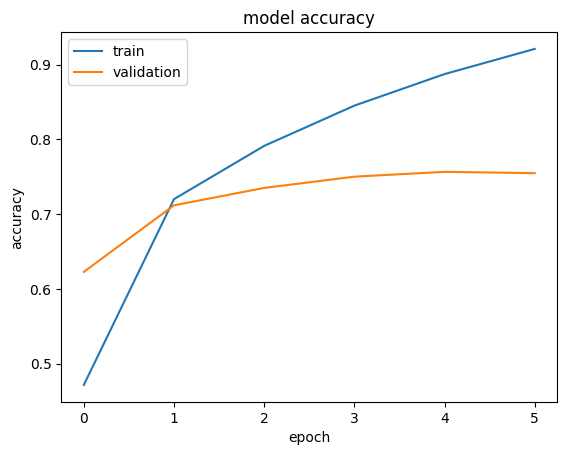

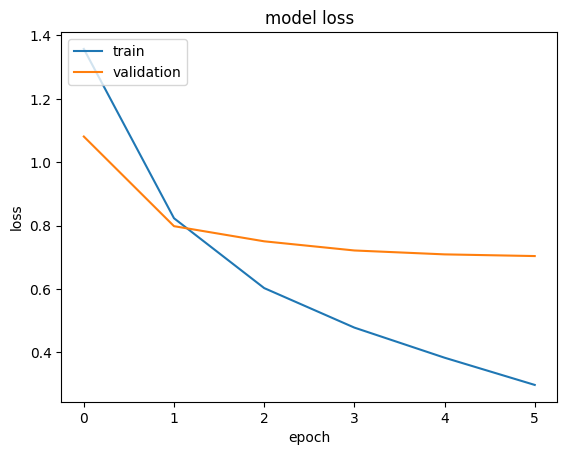

In [ ]:
# 准确率
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 损失值
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 4. 模型评估

In [ ]:
predictions = model.predict(X_test_pad)  # 对测试数据进行预测

# 概率分布转换为类别标签
predictions = np.argmax(predictions, axis=1)

# 类别索引转换为具体的类别名称
predictions = [class_names[pred] for pred in predictions]


107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 185ms/step


In [ ]:
# 准确率和 F1 分数
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))


Accuracy: 75.48%

F1 Score: 75.48


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    title = 'Confusion matrix'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



F1 Score: 75.48


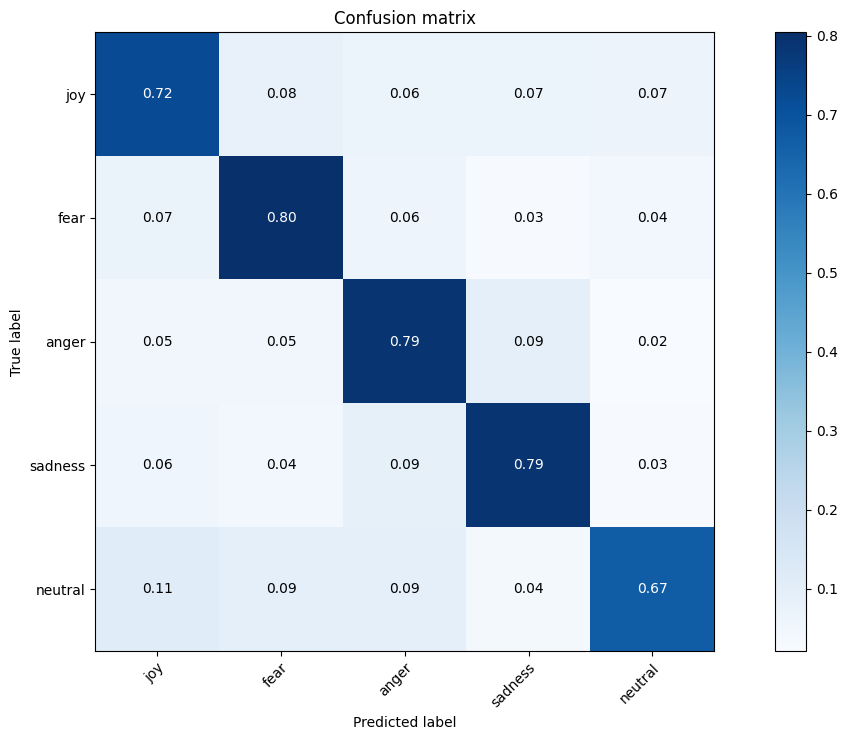

In [ ]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='归一化混淆矩阵')
plt.show()


### 看看输入和输出

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[0], predictions[0]))

Message: I experienced this emotion when my grandfather passed away.
Predicted: sadness


In [ ]:
import time

message = ['delivery was hour late and my pizza was cold!']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Message: ['delivery was hour late and my pizza was cold!']
predicted: anger (0.11 seconds)


# 保存/部署


In [ ]:

model.save('models/cnn_w2v.h5')

In [ ]:
from keras.models import load_model
predictor = load_model('models/cnn_w2v.h5')